<a href="https://colab.research.google.com/github/rajeshmore1/RNN-Tutorial/blob/main/RNN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network
Recurrent Neural Networks are designed to handle sequential data by incorporating the essential dimension of time. This type of data appears everywhere from the prediction of stock prices to the modelling of language, so it’s an essential skillset for someone interesting in getting into deep learning.

This article will cover:

* A demonstration of properly vectorizing data for a sequential model
* A discussion on how to shape data for recurrent neural networks
* Implementation of RNNs, LSTMs, GRUs, and Embeddings
* Best practices and tips in building effective deep models

We will be training a recurrent neural network to predict Apple stock prices. We can collect this from the pandas_datareader. The stock data is stored into a DataFrame named df.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime #necessary for creating a datetime object
import pandas_datareader as pdr #necessary for downloading the stock data from Yahoo! Finance
# you need to install this li

In [ ]:
!pip install yfinance
!pip install yahoofinancials

import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
#If you do not have these libraries, you can install them via pip.



In [ ]:
df = yf.download('AAPL')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099450,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094261,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087343,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089504,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092099,73449600


### We’ll predict the closing prices, which can be accessed in the Close column. These prices will be separated into a training set and a testing set.

In [ ]:
prices = df['Close']
train = list(prices)[:5000] #first 5000 prices
test = list(prices)[5000:] #remaining prices

In [22]:
prices.head()

Date
1980-12-12    0.128348
1980-12-15    0.121652
1980-12-16    0.112723
1980-12-17    0.115513
1980-12-18    0.118862
Name: Close, dtype: float64

Currently, train and test are long sequences of stock prices. We would like to convert these sequences into x and y sets, where x represents a sequence of prices and y is the next price.

Consider the following sequence:

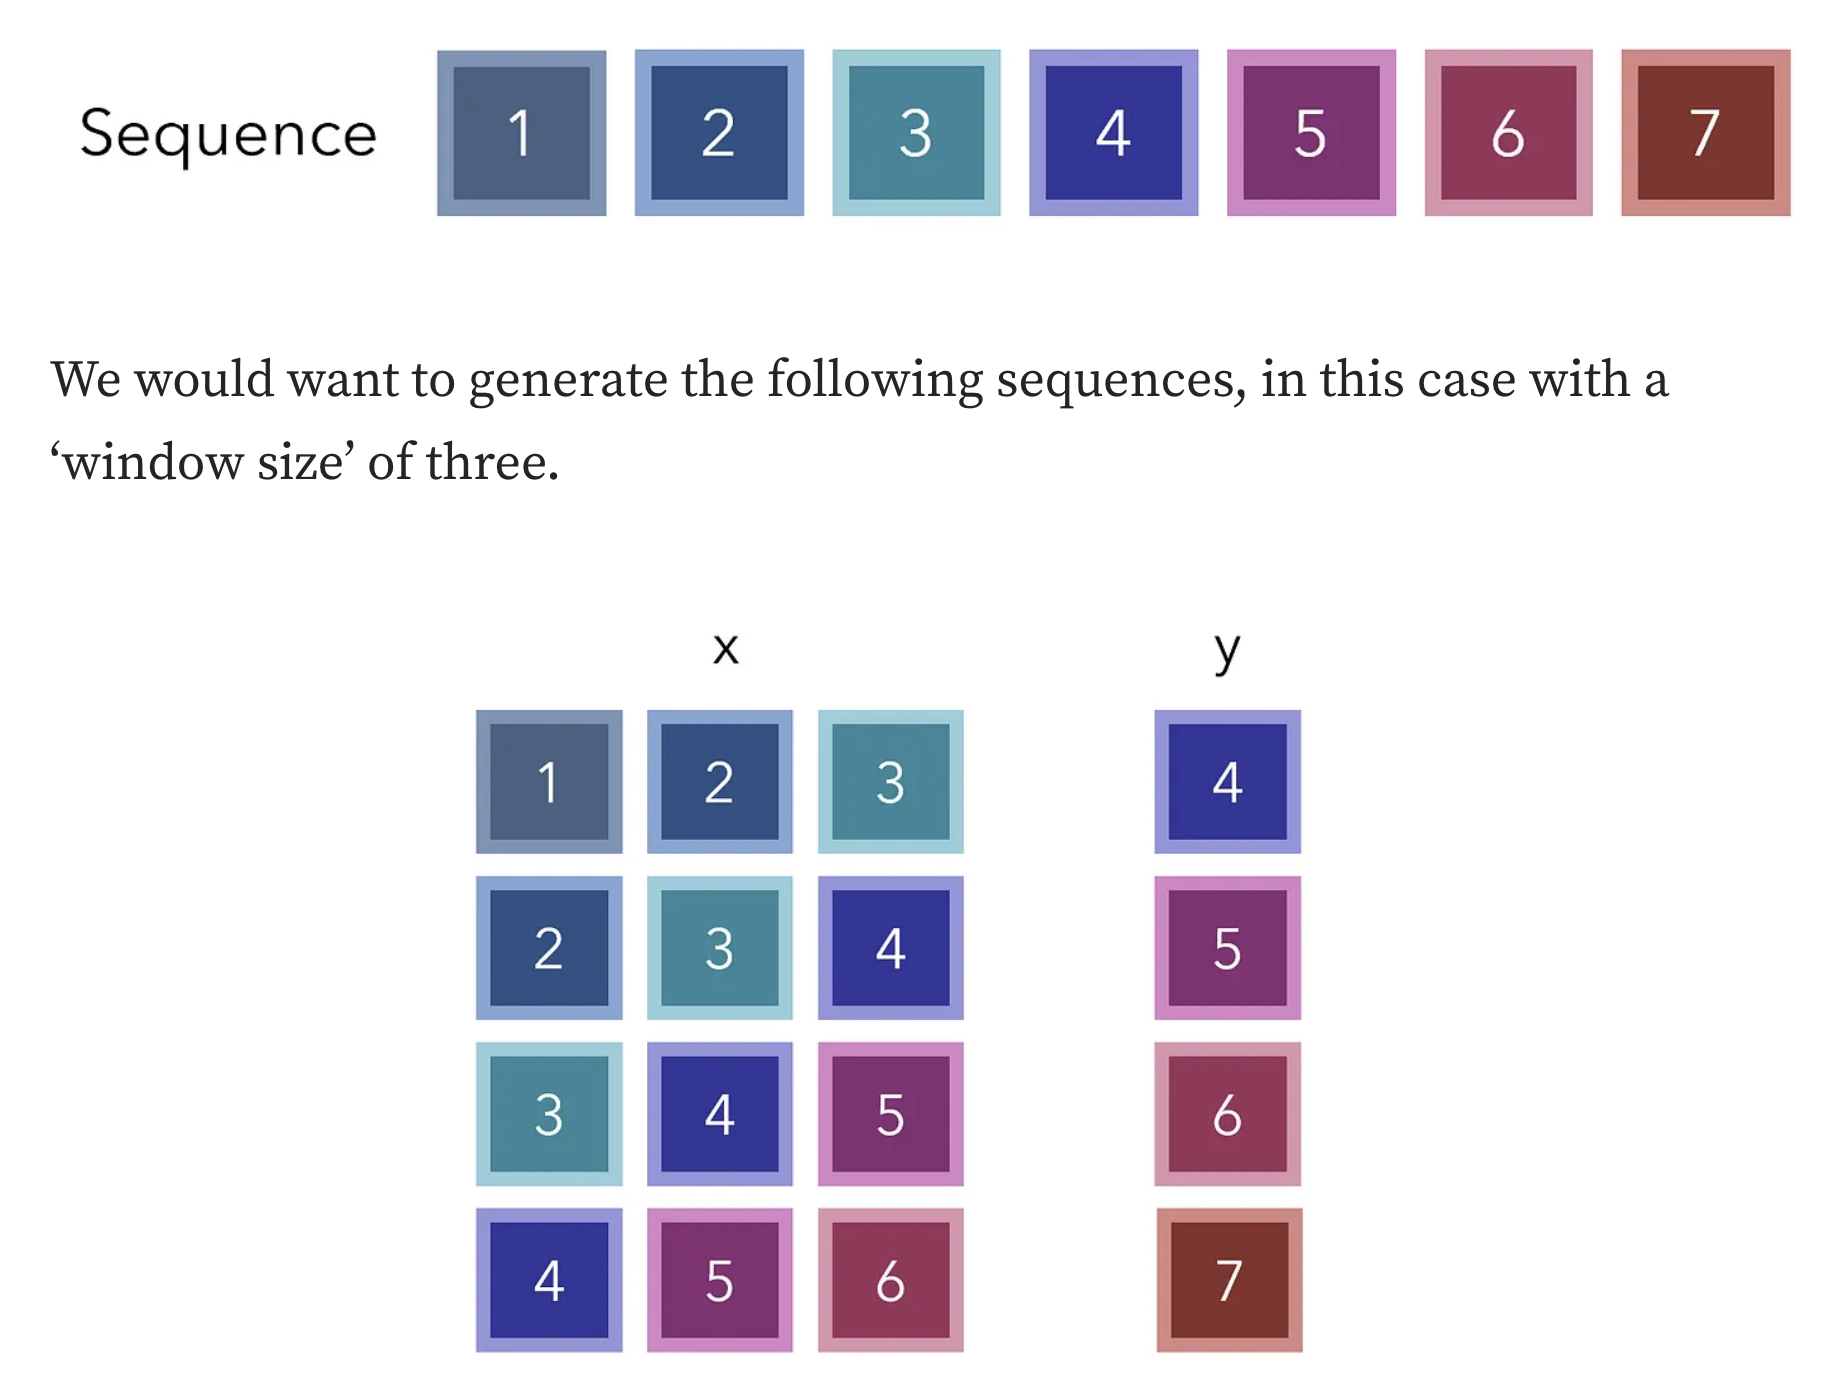

This can be programmed using the following code:



In [23]:
windowSize, X_train, y_train = 50, [], [] #initialize lists and set window size
for index in range(len(train)-windowSize): #we must end at train-windowSize to avoid the windowSize going past the end
    X_train.append(train[index:index+windowSize]) #append the range from index to index+windowSize to x
    y_train.append(train[index+windowSize]) #append the next value to the y

In [27]:
X_train[0]

[0.1283479928970337,
 0.12165199965238571,
 0.11272300034761429,
 0.11551299691200256,
 0.11886200308799744,
 0.12611599266529083,
 0.1322540044784546,
 0.13783499598503113,
 0.14508900046348572,
 0.15848200023174286,
 0.16071400046348572,
 0.156808003783226,
 0.1523440033197403,
 0.15401799976825714,
 0.15067000687122345,
 0.1439729928970337,
 0.13783499598503113,
 0.13504500687122345,
 0.14229899644851685,
 0.141183003783226,
 0.13616099953651428,
 0.1367190033197403,
 0.13950900733470917,
 0.13839299976825714,
 0.14676299691200256,
 0.14229899644851685,
 0.14508900046348572,
 0.14676299691200256,
 0.14620499312877655,
 0.1439729928970337,
 0.14285700023174286,
 0.13839299976825714,
 0.1333709955215454,
 0.12611599266529083,
 0.11886200308799744,
 0.12332600355148315,
 0.12779000401496887,
 0.12779000401496887,
 0.1283479928970337,
 0.12165199965238571,
 0.12165199965238571,
 0.11774600297212601,
 0.11662899702787399,
 0.11383900046348572,
 0.11662899702787399,
 0.12165199965238571,


In [28]:
y_train[0]

0.11272300034761429

Great! We’ve collected our training data. One more thing, though — currently the data is in list form. In order to run it through a Keras model, data must almost always be in array form. Additionally, the X must be a three-dimensional array — in this case, we reshape the third dimension of X as 1.

In [29]:
X_train,y_train = np.array(X_train), np.array(y_train) #convert to numpy array
X_train = X_train.reshape((len(X_train), 50, 1)) #reshape X_train to proper 3-d array

It’s worth exploring why RNNs require a three-dimensional input (at least, their implementations in Keras). In the case of stock prediction, at each time step, there is only one data point — the stock price.

However, consider a RNN learning to generate a sequence of movements up, down, right, and left; each time step has four values (a 1or a 0 for each direction). For example, right might be represented as [0, 0, 1, 0]. If there are 5000 items in the training set and each had a sequence length of 10 movements, the shape of the data would be (5000, 10, 4).

Similarly, in text generation that is character-by-character based, each time step has at least 26 different values of 0s or 1s, indicating letters of the alphabet. Often, additional characters include punctuation or spaces. This idea will be iterated upon more later.

Now that the training data has been created, we can get started constructing the recurrent neural network. The simplest RNN has two layers: a standard recurrent layer and a standard dense layer, which will be connected through a Sequential model. We can go ahead and import these.

In [30]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense


We can begin creating a recurrent neural network now. Although it’s not entirely accurate, one can think of the 10 in SimpleRNN(10, …) as having ’10 neurons’, much like a dense layer. Since we are predicting single values on a continuous scale, the last dense layer has one neuron and a linear activation.

Because our sequences have 50 elements and each can be represented using only one value (opposed to something like 26 for the alphabet), the input shape of a sequence is (50, 1).

In [31]:
model = Sequential() #initializing sequential model, layers can be added sequentially with model.add
model.add(SimpleRNN(10, input_shape=(50,1))) #simple recurrent layer, 10 neurons & process 50x1 sequences
model.add(Dense(1,activation='linear')) #linear output because this is a regression problem


Lastly, the Keras model must be compiled with a loss (default mean squared error for regression), an optimizer (Adam is a default), and optional metrics to track the progress (mean absolute error). We’ll train the model on X_train and y_train for 500 epochs and save training data to history.

In [33]:
model.compile(loss='mse', optimizer='Adam', metrics=['mae'])
history = model.fit(X_train,y_train,epochs=30)

Epoch 1/30
155/155 [==============================] - 2s 9ms/step - loss: 2.0803e-04 - mae: 0.0093
Epoch 2/30
155/155 [==============================] - 2s 16ms/step - loss: 1.8874e-04 - mae: 0.0086
Epoch 3/30
155/155 [==============================] - 1s 10ms/step - loss: 1.8941e-04 - mae: 0.0086
Epoch 4/30
155/155 [==============================] - 1s 8ms/step - loss: 1.9558e-04 - mae: 0.0089
Epoch 5/30
155/155 [==============================] - 1s 9ms/step - loss: 1.9953e-04 - mae: 0.0090
Epoch 6/30
155/155 [==============================] - 1s 9ms/step - loss: 2.0006e-04 - mae: 0.0090
Epoch 7/30
155/155 [==============================] - 1s 9ms/step - loss: 1.8482e-04 - mae: 0.0083
Epoch 8/30
155/155 [==============================] - 1s 9ms/step - loss: 1.8548e-04 - mae: 0.0086
Epoch 9/30
155/155 [==============================] - 1s 9ms/step - loss: 1.8987e-04 - mae: 0.0087
Epoch 10/30
155/155 [==============================] - 2s 11ms/step - loss: 1.9488e-04 - mae: 0.0089
Epoch 

A recurrent layer can be thought of as parsing several inputs, taking into account sequential order — if it helps, it’s can be thought of as a derivative, finding a generalizable pattern across sequences. Stacking two recurrent layers, then, is like taking a double derivative, or the ‘difference of the difference’. Much like stacking multiple convolutional layers, it allows for more complex relationships to be identified.

If one tries to stack two recurrent layers naively, it won’t work: a parameter, return_sequences=True, must be added. This returns the output as a sequence that can be inputted into another recurrent layer. We may decide to design a deep recurrent neural network with several stacked layers as follows:

In [35]:
model = Sequential() #initialize model
model.add(SimpleRNN(64, input_shape=(50,1), return_sequences=True)) #recurrent layer 1, 64 neurons
model.add(SimpleRNN(32, return_sequences=True)) #recurrent layer 2, 32 neurons
model.add(SimpleRNN(16)) #recurrent layer 3, 16 neurons
model.add(Dense(8,activation='tanh')) #Dense layer, 8 neurons w/ tanh activation
model.add(Dense(1,activation='linear')) #output dense layer (1 neuron) w/ linear activation

model.compile(loss='mse', optimizer='Adam', metrics=['mae']) #standard compiling
history = model.fit(X_train,y_train,epochs=30) #standard history collection & fitting

Epoch 1/30
155/155 [==============================] - 9s 37ms/step - loss: 0.0025 - mae: 0.0272
Epoch 2/30
155/155 [==============================] - 5s 31ms/step - loss: 5.4156e-04 - mae: 0.0160
Epoch 3/30
155/155 [==============================] - 6s 39ms/step - loss: 4.1517e-04 - mae: 0.0139
Epoch 4/30
155/155 [==============================] - 5s 31ms/step - loss: 3.5080e-04 - mae: 0.0128
Epoch 5/30
155/155 [==============================] - 7s 46ms/step - loss: 3.6896e-04 - mae: 0.0133
Epoch 6/30
155/155 [==============================] - 6s 39ms/step - loss: 2.9296e-04 - mae: 0.0116
Epoch 7/30
155/155 [==============================] - 6s 37ms/step - loss: 2.7522e-04 - mae: 0.0114
Epoch 8/30
155/155 [==============================] - 5s 32ms/step - loss: 2.8776e-04 - mae: 0.0119
Epoch 9/30
155/155 [==============================] - 5s 31ms/step - loss: 3.1044e-04 - mae: 0.0127
Epoch 10/30
155/155 [==============================] - 6s 39ms/step - loss: 2.6058e-04 - mae: 0.0112
Epo

LSTMs, or Long Short-Term Memory networks, are an improvement upon naïve recurrent neural networks because they can ‘memorize’ important information across long input sequences. The interface for using LSTMs is the same for the SimpleRNN layer.

In [36]:
from keras.layers import LSTM
model = Sequential() #initialize sequential model
model.add(LSTM(10, input_shape=(50,1))) #LSTM layer with 10 neurons
model.add(Dense(1,activation='linear')) #Dense output layer with 1 neuron, linear activation
#compile & fit

Like RNNs, LSTMs can be stacked to develop complexity and deeper understanding of patterns in the inputs. Note that because Long Short-Term Memory networks have a variety of memory mechanisms, they are more expensive to train than standard recurrent neural networks.

In [37]:
model = Sequential() #initialize sequential model
model.add(LSTM(64, input_shape=(50,1), return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32, return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32)) #LSTM layer with 32 neurons
model.add(Dense(16,activation='relu')) #Dense layer with 16 neurons
model.add(Dense(8,activation='relu')) #Dense layer with 8 neurons
model.add(Dense(1,activation='linear')) #Dense output layer with 1 neuron, linear activation
#compile & fit